In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import pickle
import gc
from tqdm.notebook import tqdm
from collections import deque

In [2]:
with open("simplified_data_v2/train_features_v3.pkl",'rb') as f:
    X = pickle.load(f)
with open("simplified_data_v2/train_labels_v3.pkl",'rb') as f:
    y = pickle.load(f)

In [3]:
y_scaled = y.clip(0,40)
y_scaled = np.log1p(y_scaled)/np.log1p(40)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled,test_size=0.2)
del X; gc.collect();

In [6]:
X_train.shape

(1932216, 2, 23)

In [7]:
model_lstm = Sequential()
model_lstm.add(LSTM(256, input_shape=(2,23), return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(64))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(units=1, activation='sigmoid'))
model_lstm.compile(loss='mse', optimizer='adam', metrics=['accuracy']) # Increase Learning rate by steps of 0.1
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 2, 256)            286720    
_________________________________________________________________
dropout (Dropout)            (None, 2, 256)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                82176     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 368,961
Trainable params: 368,961
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128)

Train on 1932216 samples, validate on 483055 samples
Epoch 1/30
1932216/1932216 [==============================] - 184s 95us/sample - loss: 0.0137 - accuracy: 0.5898 - val_loss: 0.0130 - val_accuracy: 0.5902
Epoch 2/30
1932216/1932216 [==============================] - 194s 100us/sample - loss: 0.0131 - accuracy: 0.5899 - val_loss: 0.0128 - val_accuracy: 0.5902
Epoch 3/30
1932216/1932216 [==============================] - 200s 104us/sample - loss: 0.0129 - accuracy: 0.5899 - val_loss: 0.0127 - val_accuracy: 0.5901
Epoch 4/30
1932216/1932216 [==============================] - 218s 113us/sample - loss: 0.0129 - accuracy: 0.5899 - val_loss: 0.0127 - val_accuracy: 0.5901
Epoch 5/30
1932216/1932216 [==============================] - 186s 97us/sample - loss: 0.0128 - accuracy: 0.5899 - val_loss: 0.0126 - val_accuracy: 0.5901
Epoch 6/30
1932216/1932216 [==============================] - 183s 95us/sample - loss: 0.0128 - accuracy: 0.5899 - val_loss: 0.0126 - val_accuracy: 0.5902
Epoch 7/30
193

In [9]:
y_pre = model_lstm.predict(X_test)

In [10]:
y_pre_unscaled = np.expm1(y_pre * np.log1p(40))
y_unscaled = np.expm1(y_test * np.log1p(40))

Val RMSE: 1.239


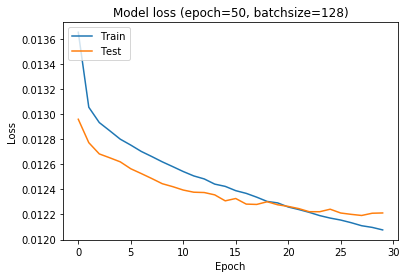

In [11]:
from sklearn.metrics import mean_squared_error
from numpy import sqrt
rmse = sqrt(mean_squared_error(y_pre_unscaled,y_unscaled))
print('Val RMSE: %.3f' % rmse)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss (epoch=50, batchsize=128)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Prediction on The Kaggle

## Keys In Trained Data

In [39]:
with open('simplified_data_v2/kaggle_pred.pkl','rb') as f:
    X_kaggle = pickle.load(f)

with open('simplified_data_v2/kaggle_pred_ids.pkl','rb') as f:
    ids = pickle.load(f)

In [40]:
y_kaggle_prediction = model_lstm.predict(X_kaggle)

In [41]:
y_kaggle_unscaled = np.expm1(y_kaggle_prediction * np.log1p(40))
y_kaggle_unscaled = y_kaggle_unscaled.clip(0,20)

In [42]:
y_kaggle_unscaled.shape

(214200, 1)

In [45]:
val = ids.reshape(-1,1)
val.shape

(214200, 1)

In [49]:
data = np.concatenate((val,y_kaggle_unscaled),axis=1)

In [52]:
df = pd.DataFrame(data=data,columns=['ID','item_cnt_month'])

In [54]:
df = df.astype({'ID':'int32'})

In [56]:
df.to_csv('simplified_data_v2/submission_please_god.csv',index=False)

In [57]:
model_lstm.save('LSTM_Model_v4.h5')
with open("LSTM_histoy_LSTM_model_v3.pkl",'wb') as f:
    pickle.dump(history.history,f)